### GENERATE DATA

In [45]:
# Import necessary libraries
from sionna.rt import load_scene, Camera, PathSolver, RadioMapSolver
import numpy as np
import matplotlib.pyplot as plt

from builders import SceneTransceiverBuilder, TransceiverConfig

In [46]:
# Create scene and set frequency
scene = load_scene(None)  # Empty scene
scene.frequency = 28e9    # 28 GHz (5G mmWave frequency)

print("Scene created and frequency set to 28 GHz")

Scene created and frequency set to 28 GHz


In [47]:
# Configure random positioning in 200x200m grid
# Grid center at origin, so coordinates range from -100 to +100 in both x and y

builder = SceneTransceiverBuilder(scene)

# Create configuration for random positioning
cfg = TransceiverConfig.randomized(
    n_tx=3,        # Number of transmitters
    n_rx=20,       # Number of receivers
    # TX positions: random within 200x200m grid (±100m from center), height 10m
    random_tx_range=((-100, 100), (-100, 100), 10.0),
    # RX positions: random within 200x200m grid (±100m from center), height 1.5m  
    random_rx_range=((-100, 100), (-100, 100), 1.5),
    tx_power_dbm=44,
    tx_array_pattern="tr38901",  # Directional antenna pattern
    polarization="V",
    seed=42  # For reproducible results
)

# Build the transceivers
builder.build(cfg)

print(f"Created {cfg.n_tx} transmitters and {cfg.n_rx} receivers")
print(f"TX height: 10m, RX height: 1.5m")
print(f"All positioned randomly within 200x200m grid")

Created 3 transmitters and 20 receivers
TX height: 10m, RX height: 1.5m
All positioned randomly within 200x200m grid


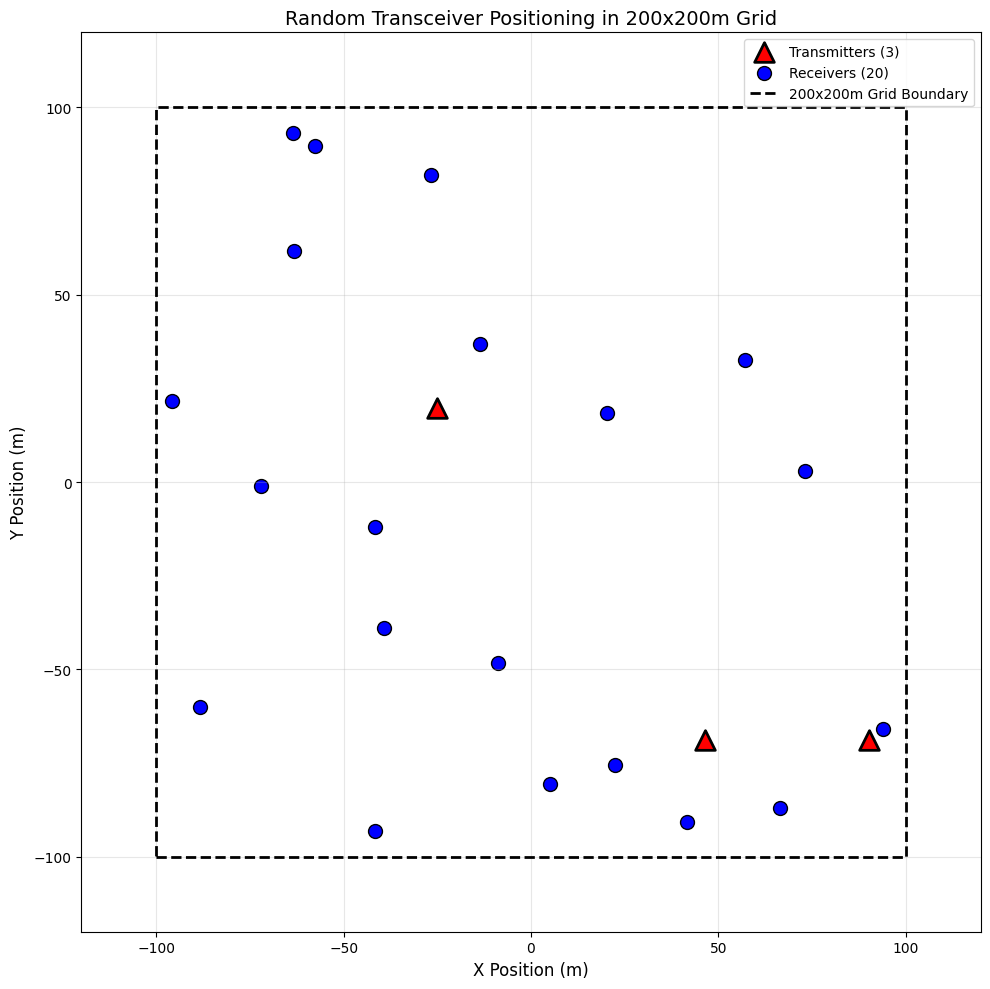

TX positions (height=10m):
  TX_1: (-25.1, 19.7, 10.0)
  TX_2: (90.1, -68.8, 10.0)
  TX_3: (46.4, -68.8, 10.0)

First 5 RX positions (height=1.5m):
  RX_1: (-88.4, -60.1, 1.5)
  RX_2: (73.2, 2.8, 1.5)
  RX_3: (20.2, 18.5, 1.5)
  RX_4: (41.6, -90.7, 1.5)
  RX_5: (-95.9, 21.5, 1.5)


/var/folders/2x/6wpkl49n4bsfkkvhr3gm3tt00000gn/T/ipykernel_18403/3136441.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  TX_{i+1}: ({float(pos[0]):.1f}, {float(pos[1]):.1f}, 10.0)")
/var/folders/2x/6wpkl49n4bsfkkvhr3gm3tt00000gn/T/ipykernel_18403/3136441.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"  RX_{i+1}: ({float(pos[0]):.1f}, {float(pos[1]):.1f}, 1.5)")


In [48]:
# Visualize the transceiver positions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Extract TX positions
tx_positions = []
for tx_name, tx in scene.transmitters.items():
    pos = tx.position.numpy()
    tx_positions.append([pos[0], pos[1]])
    
# Extract RX positions  
rx_positions = []
for rx_name, rx in scene.receivers.items():
    pos = rx.position.numpy()
    rx_positions.append([pos[0], pos[1]])

tx_positions = np.array(tx_positions)
rx_positions = np.array(rx_positions)

# Plot the positions
ax.scatter(tx_positions[:, 0], tx_positions[:, 1], 
          c='red', s=200, marker='^', label=f'Transmitters ({len(tx_positions)})', 
          edgecolors='black', linewidth=2)
ax.scatter(rx_positions[:, 0], rx_positions[:, 1], 
          c='blue', s=100, marker='o', label=f'Receivers ({len(rx_positions)})',
          edgecolors='black', linewidth=1)

# Add grid boundaries
ax.plot([-100, 100, 100, -100, -100], [-100, -100, 100, 100, -100], 
        'k--', linewidth=2, label='200x200m Grid Boundary')

ax.set_xlim(-120, 120)
ax.set_ylim(-120, 120)
ax.set_xlabel('X Position (m)', fontsize=12)
ax.set_ylabel('Y Position (m)', fontsize=12)
ax.set_title('Random Transceiver Positioning in 200x200m Grid', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"TX positions (height=10m):")
for i, pos in enumerate(tx_positions):
    print(f"  TX_{i+1}: ({float(pos[0]):.1f}, {float(pos[1]):.1f}, 10.0)")
    
print(f"\nFirst 5 RX positions (height=1.5m):")
for i, pos in enumerate(rx_positions[:5]):
    print(f"  RX_{i+1}: ({float(pos[0]):.1f}, {float(pos[1]):.1f}, 1.5)")

In [49]:
# Generate radio map for the 200x200m grid
print("Computing radio map... (this may take a moment)")

# Set up radio map solver
rm_solver = RadioMapSolver()
rm = rm_solver(
    scene,
    max_depth=5,              # Ray bouncing depth
    samples_per_tx=10**6,     # Monte Carlo samples (1M for good quality)
    cell_size=(2, 2),         # 2m x 2m grid cells
    center=[0, 0, 0],         # Center at origin
    size=[200, 200],          # 200m x 200m coverage area
    orientation=[0, 0, 0]     # No rotation
)

print("Radio map computation complete!")
print(f"Grid resolution: {200/2} x {200/2} = {(200/2)**2} cells")
print(f"Cell size: 2m x 2m")

Computing radio map... (this may take a moment)
Radio map computation complete!
Grid resolution: 100.0 x 100.0 = 10000.0 cells
Cell size: 2m x 2m


Displaying RSS (Received Signal Strength) radio map:

Displaying SINR (Signal-to-Interference-plus-Noise Ratio) radio map:

Radio maps generated for 200x200m area:
- RSS shows raw signal strength at each location
- SINR shows signal quality considering interference
- Brighter colors indicate stronger signals/better quality


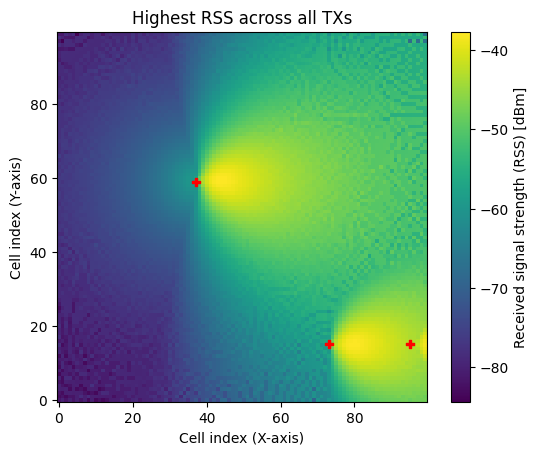

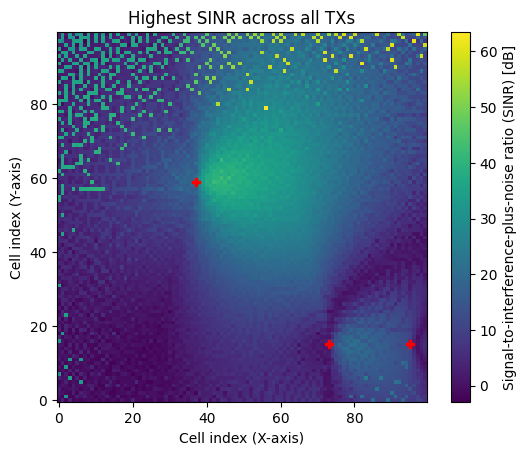

In [50]:
# Display the radio maps
print("Displaying RSS (Received Signal Strength) radio map:")
rm.show(metric="rss")

print("\nDisplaying SINR (Signal-to-Interference-plus-Noise Ratio) radio map:")
rm.show(metric="sinr")

print("\nRadio maps generated for 200x200m area:")
print("- RSS shows raw signal strength at each location")
print("- SINR shows signal quality considering interference")
print("- Brighter colors indicate stronger signals/better quality")

## Key Parameters for 200x200m Random Grid

### Grid Configuration:
- **Area**: 200m × 200m centered at origin
- **TX Range**: (-100, +100) in both X and Y directions  
- **RX Range**: (-100, +100) in both X and Y directions
- **TX Height**: 10m (typical base station height)
- **RX Height**: 1.5m (typical user equipment height)

### Transceiver Setup:
- **Number of TX**: 3 (configurable)
- **Number of RX**: 20 (configurable) 
- **TX Power**: 44 dBm
- **Antenna Pattern**: TR38901 (3GPP 5G standard)
- **Polarization**: Vertical

### Radio Map Settings:
- **Cell Size**: 2m × 2m (100×100 grid cells)
- **Coverage**: Full 200m × 200m area
- **Ray Tracing Depth**: 5 bounces
- **Monte Carlo Samples**: 1M per transmitter

### Customization Options:
You can easily modify the configuration by changing the `TransceiverConfig.randomized()` parameters:
- Adjust `n_tx` and `n_rx` for different numbers of transceivers
- Change `random_tx_range` and `random_rx_range` for different grid sizes
- Modify heights by changing the third value in the range tuples
- Use different `seed` values for different random layouts

## Generate Multiple Random Configurations

Now we'll create a data generation pipeline that:
1. Creates multiple random transceiver configurations
2. Generates SINR maps for each configuration
3. Stores the data for machine learning or analysis

In [51]:
import time
import pickle
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class DataSample:
    """Structure to store each data sample"""
    sample_id: int
    tx_positions: np.ndarray  # Shape: (n_tx, 3)
    rx_positions: np.ndarray  # Shape: (n_rx, 3) 
    sinr_map: np.ndarray      # Shape: (grid_height, grid_width)
    config: Dict[str, Any]    # Configuration parameters
    
class RadioMapDataGenerator:
    """Generate multiple radio map datasets with random transceiver positions"""
    
    def __init__(self, scene, grid_size=(200, 200), cell_size=(2, 2)):
        self.scene = scene
        self.builder = SceneTransceiverBuilder(scene)
        self.rm_solver = RadioMapSolver()
        self.grid_size = grid_size
        self.cell_size = cell_size
        self.samples = []
        
    def generate_sample(self, sample_id: int, config_params: Dict[str, Any]) -> DataSample:
        """Generate a single data sample with random transceiver positions"""
        
        # Create random configuration
        cfg = TransceiverConfig.randomized(**config_params)
        
        # Build transceivers in scene
        self.builder.build(cfg)
        
        # Extract positions - fix the dimension issue
        tx_positions = []
        for tx in self.scene.transmitters.values():
            pos = tx.position.numpy()
            # Remove extra dimensions and ensure we get [x, y, z]
            if pos.ndim > 1:
                pos = pos.squeeze()
            tx_positions.append([float(pos[0]), float(pos[1]), float(pos[2])])
        
        rx_positions = []
        for rx in self.scene.receivers.values():
            pos = rx.position.numpy()
            # Remove extra dimensions and ensure we get [x, y, z]
            if pos.ndim > 1:
                pos = pos.squeeze()
            rx_positions.append([float(pos[0]), float(pos[1]), float(pos[2])])
        
        tx_positions = np.array(tx_positions)  # Shape: (n_tx, 3)
        rx_positions = np.array(rx_positions)  # Shape: (n_rx, 3)
        
        # Generate radio map
        rm = self.rm_solver(
            self.scene,
            max_depth=5,
            samples_per_tx=10**6,
            cell_size=self.cell_size,
            center=[0, 0, 0],
            size=list(self.grid_size),
            orientation=[0, 0, 0]
        )
        
        # Extract SINR data - fix the dimension issue
        sinr_data = rm.sinr.numpy()
        # If SINR has multiple transmitters, take the maximum or mean across transmitters
        if sinr_data.ndim == 3:  # Shape: (n_tx, height, width)
            sinr_map = np.max(sinr_data, axis=0)  # Take max SINR across all transmitters
        else:
            sinr_map = sinr_data
        
        # Create data sample
        sample = DataSample(
            sample_id=sample_id,
            tx_positions=tx_positions,
            rx_positions=rx_positions,
            sinr_map=sinr_map,
            config=config_params
        )
        
        return sample
    
    def generate_dataset(self, n_samples: int, config_template: Dict[str, Any], 
                        show_progress: bool = True) -> List[DataSample]:
        """Generate multiple data samples"""
        
        print(f"Generating {n_samples} data samples...")
        dataset = []
        
        for i in range(n_samples):
            if show_progress and (i + 1) % 5 == 0:
                print(f"Generated {i + 1}/{n_samples} samples")
            
            # Use different seed for each sample to get different random positions
            config = config_template.copy()
            config['seed'] = i + 100  # Start from 100 to avoid conflicts
            
            sample = self.generate_sample(i + 1, config)
            dataset.append(sample)
            
        print(f"Dataset generation complete: {len(dataset)} samples")
        return dataset
    
    def save_dataset(self, dataset: List[DataSample], filename: str):
        """Save dataset to pickle file"""
        with open(filename, 'wb') as f:
            pickle.dump(dataset, f)
        print(f"Dataset saved to {filename}")
        
    def load_dataset(self, filename: str) -> List[DataSample]:
        """Load dataset from pickle file"""
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        print(f"Dataset loaded from {filename}: {len(dataset)} samples")
        return dataset

print("RadioMapDataGenerator class defined")

RadioMapDataGenerator class defined


In [52]:
# Configuration for data generation
config = {
    'n_tx': 3,                                           # Number of transmitters
    'n_rx': 20,                                          # Number of receivers  
    'random_tx_range': ((-100, 100), (-100, 100), 10.0), # TX positions
    'random_rx_range': ((-100, 100), (-100, 100), 1.5),  # RX positions
    'tx_power_dbm': 44,
    'tx_array_pattern': 'tr38901',
    'polarization': 'V'
}

# Create data generator
generator = RadioMapDataGenerator(scene, grid_size=(200, 200), cell_size=(2, 2))

print("Data generator configured:")
print(f"- Grid size: {generator.grid_size[0]}x{generator.grid_size[1]}m")
print(f"- Cell size: {generator.cell_size[0]}x{generator.cell_size[1]}m")
print(f"- Grid resolution: {generator.grid_size[0]//generator.cell_size[0]} x {generator.grid_size[1]//generator.cell_size[1]} cells")

Data generator configured:
- Grid size: 200x200m
- Cell size: 2x2m
- Grid resolution: 100 x 100 cells


In [53]:
# Recreate the generator with the fixed class
generator = RadioMapDataGenerator(scene, grid_size=(200, 200), cell_size=(2, 2))

# Generate a small dataset (start with 10 samples for testing)
n_samples = 10
start_time = time.time()

dataset = generator.generate_dataset(n_samples, config, show_progress=True)

end_time = time.time()
print(f"\nDataset generation completed in {end_time - start_time:.1f} seconds")
print(f"Average time per sample: {(end_time - start_time) / n_samples:.1f} seconds")

Generating 10 data samples...
Generated 5/10 samples
Generated 5/10 samples
Generated 10/10 samples
Dataset generation complete: 10 samples

Dataset generation completed in 0.9 seconds
Average time per sample: 0.1 seconds
Generated 10/10 samples
Dataset generation complete: 10 samples

Dataset generation completed in 0.9 seconds
Average time per sample: 0.1 seconds


In [54]:
# Examine the generated dataset
print(f"Dataset contains {len(dataset)} samples")
print(f"\nFirst sample details:")
sample = dataset[0]
print(f"- Sample ID: {sample.sample_id}")
print(f"- TX positions shape: {sample.tx_positions.shape}")
print(f"- RX positions shape: {sample.rx_positions.shape}")
print(f"- SINR map shape: {sample.sinr_map.shape}")

print(f"\nTX positions for sample 1:")
for i, pos in enumerate(sample.tx_positions):
    print(f"  TX_{i+1}: ({pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f})")
    
print(f"\nFirst 3 RX positions for sample 1:")
for i, pos in enumerate(sample.rx_positions[:3]):
    print(f"  RX_{i+1}: ({pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f})")

print(f"\nSINR map statistics:")
print(f"- Min SINR: {sample.sinr_map.min():.2f} dB")
print(f"- Max SINR: {sample.sinr_map.max():.2f} dB") 
print(f"- Mean SINR: {sample.sinr_map.mean():.2f} dB")

Dataset contains 10 samples

First sample details:
- Sample ID: 1
- TX positions shape: (3, 3)
- RX positions shape: (20, 3)
- SINR map shape: (100, 100)

TX positions for sample 1:
  TX_1: (8.7, 69.0, 10.0)
  TX_2: (-44.3, -99.1, 10.0)
  TX_3: (-15.1, -75.7, 10.0)

First 3 RX positions for sample 1:
  RX_1: (34.1, -98.9, 1.5)
  RX_2: (65.2, -49.5, 1.5)
  RX_3: (-72.7, 59.1, 1.5)

SINR map statistics:
- Min SINR: 0.51 dB
- Max SINR: 40521248.00 dB
- Mean SINR: 138122.55 dB


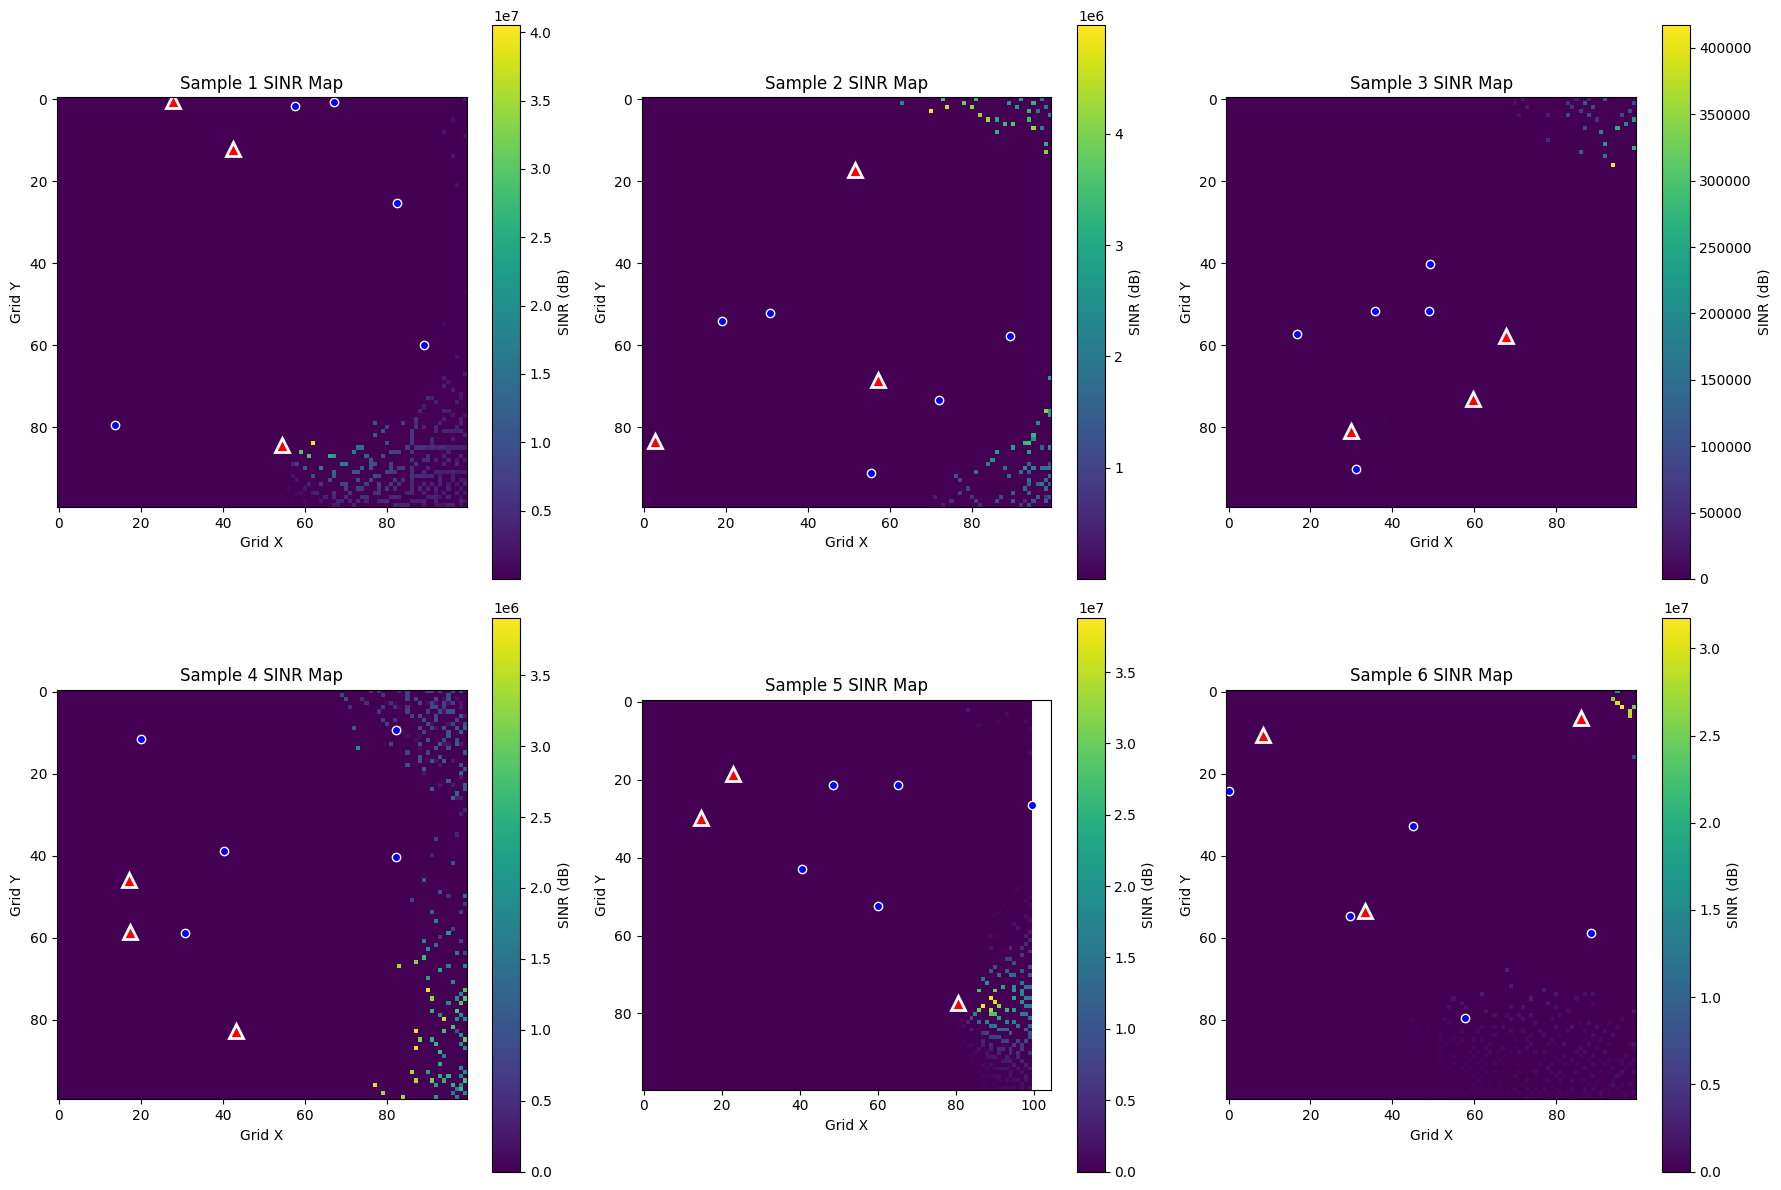

Visualization shows:
- Red triangles: Transmitter positions
- Blue circles: First 5 receiver positions
- Color map: SINR values (brighter = better signal quality)


In [55]:
# Visualize a few samples from the dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Show first 6 samples
for i in range(min(6, len(dataset))):
    sample = dataset[i]
    
    # Plot SINR map
    im = axes[i].imshow(sample.sinr_map, cmap='viridis', aspect='equal')
    
    # Overlay transceiver positions (need to convert to grid coordinates)
    grid_height, grid_width = sample.sinr_map.shape
    
    # Convert world coordinates to grid coordinates
    # Grid spans from -100 to +100 in both directions
    def world_to_grid(pos, grid_size, world_size):
        # pos: world coordinates, grid_size: pixels, world_size: meters
        return ((pos + world_size/2) / world_size) * grid_size
    
    # Plot TX positions
    for tx_pos in sample.tx_positions:
        grid_x = world_to_grid(tx_pos[0], grid_width, 200)
        grid_y = world_to_grid(tx_pos[1], grid_height, 200)
        axes[i].plot(grid_x, grid_y, 'r^', markersize=10, markeredgecolor='white', markeredgewidth=2)
    
    # Plot RX positions (just first few to avoid clutter)
    for rx_pos in sample.rx_positions[:5]:
        grid_x = world_to_grid(rx_pos[0], grid_width, 200)
        grid_y = world_to_grid(rx_pos[1], grid_height, 200)
        axes[i].plot(grid_x, grid_y, 'bo', markersize=6, markeredgecolor='white', markeredgewidth=1)
    
    axes[i].set_title(f'Sample {sample.sample_id} SINR Map', fontsize=12)
    axes[i].set_xlabel('Grid X')
    axes[i].set_ylabel('Grid Y')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], label='SINR (dB)')

plt.tight_layout()
plt.show()

print("Visualization shows:")
print("- Red triangles: Transmitter positions")
print("- Blue circles: First 5 receiver positions") 
print("- Color map: SINR values (brighter = better signal quality)")

In [56]:
# Save the dataset for later use
filename = "data/radio_map_dataset_20pts.pkl"
generator.save_dataset(dataset, filename)

# Calculate file size
import os
file_size = os.path.getsize(filename) / (1024 * 1024)  # MB
print(f"Dataset file size: {file_size:.2f} MB")

print(f"\nDataset summary:")
print(f"- Number of samples: {len(dataset)}")
print(f"- Transmitters per sample: {dataset[0].tx_positions.shape[0]}")
print(f"- Receivers per sample: {dataset[0].rx_positions.shape[0]}")
print(f"- SINR map resolution: {dataset[0].sinr_map.shape}")
print(f"- Grid coverage: 200x200m")
print(f"- Cell size: 2x2m")
print(f"- Total file size: {file_size:.2f} MB")

Dataset saved to data/radio_map_dataset_20pts.pkl
Dataset file size: 0.39 MB

Dataset summary:
- Number of samples: 10
- Transmitters per sample: 3
- Receivers per sample: 20
- SINR map resolution: (100, 100)
- Grid coverage: 200x200m
- Cell size: 2x2m
- Total file size: 0.39 MB


## Scaling Up Data Generation

For machine learning applications, you'll typically want larger datasets. Here's how to scale up:

### For larger datasets:
```python
# Generate 100 samples (will take longer)
large_dataset = generator.generate_dataset(100, config, show_progress=True)

# For even larger datasets (1000+ samples), consider:
# 1. Reducing samples_per_tx for faster computation
# 2. Using smaller grid resolution (larger cell_size)
# 3. Parallel processing across multiple cores
# 4. Batch processing and incremental saving
```

### Memory considerations:
- Each sample contains a 100x100 SINR map (40KB)
- 1000 samples ≈ 40MB + metadata
- For very large datasets, consider HDF5 format instead of pickle

### Performance tips:
- Use `samples_per_tx=10**5` for faster generation (lower quality)
- Increase `cell_size=(5, 5)` for coarser but faster maps
- Process in batches to avoid memory issues

## Using Real 3D Scenes (Etoile Scene)

Now let's demonstrate how to generate data using a real 3D environment instead of an empty scene:

Etoile scene loaded successfully
Scene frequency: 28.0 GHz


/var/folders/2x/6wpkl49n4bsfkkvhr3gm3tt00000gn/T/ipykernel_18403/1873446969.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  freq_value = float(scene_etoile.frequency.numpy())


Scene rendered - this shows the 3D environment structure


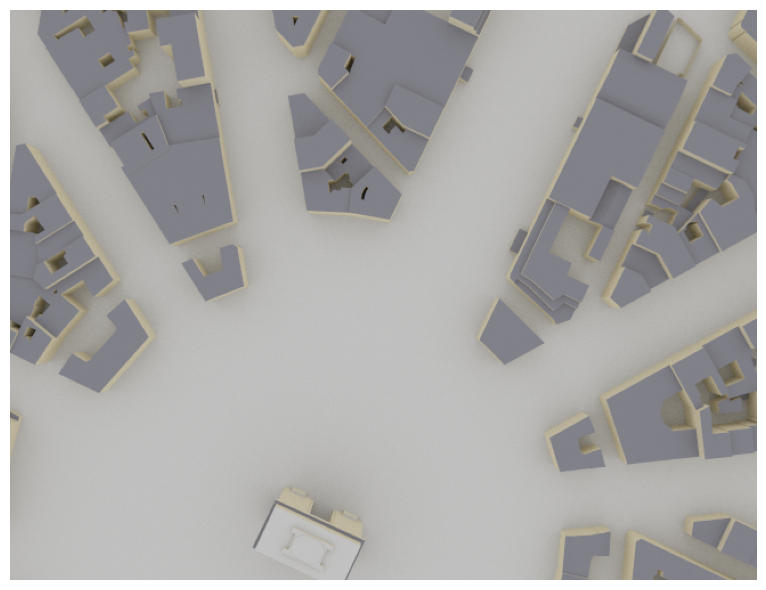

In [57]:
# Load the Etoile scene (a realistic 3D environment)
import sionna
scene_etoile = load_scene(sionna.rt.scene.etoile)
scene_etoile.frequency = 28e9  # Set frequency

print("Etoile scene loaded successfully")
# Convert Mitsuba tensor to numpy first, then to float
freq_value = float(scene_etoile.frequency.numpy())
print(f"Scene frequency: {freq_value/1e9:.1f} GHz")

# Visualize the scene first to understand the layout
camera = Camera(position=[0, 0, 500], look_at=[0, 0, 0])
scene_etoile.render(camera=camera, num_samples=512)
print("Scene rendered - this shows the 3D environment structure")

In [58]:
# Configuration for Etoile scene - adjusted for realistic building environment
# Etoile scene spans roughly -300 to +300 meters in X and Y
etoile_config = {
    'n_tx': 3,        # Number of transmitters (base stations)
    'n_rx': 15,       # Number of receivers (user equipment)
    
    # TX positions: Place on building rooftops/elevated positions
    'random_tx_range': ((-200, 200), (-200, 200), 25.0),  # Height: 25m (rooftop level)
    
    # RX positions: Ground level and lower floors  
    'random_rx_range': ((-250, 250), (-250, 250), 1.5),   # Height: 1.5m (user level)
    
    'tx_power_dbm': 46,           # Higher power for urban environment
    'tx_array_pattern': 'tr38901', # Directional antenna for better coverage
    'polarization': 'V',
    'look_at': [0, 0, 1]          # Point towards city center
}

# Create generator for Etoile scene
etoile_generator = RadioMapDataGenerator(
    scene_etoile, 
    grid_size=(500, 500),  # Larger coverage area for urban environment
    cell_size=(5, 5)       # 5m resolution (good for urban planning)
)

print("Etoile scene data generator configured:")
print(f"- Coverage area: {etoile_generator.grid_size[0]}x{etoile_generator.grid_size[1]}m")
print(f"- Cell resolution: {etoile_generator.cell_size[0]}x{etoile_generator.cell_size[1]}m")
print(f"- Grid cells: {etoile_generator.grid_size[0]//etoile_generator.cell_size[0]} x {etoile_generator.grid_size[1]//etoile_generator.cell_size[1]}")
print(f"- TX range: {etoile_config['random_tx_range']}")
print(f"- RX range: {etoile_config['random_rx_range']}")

Etoile scene data generator configured:
- Coverage area: 500x500m
- Cell resolution: 5x5m
- Grid cells: 100 x 100
- TX range: ((-200, 200), (-200, 200), 25.0)
- RX range: ((-250, 250), (-250, 250), 1.5)


In [59]:
# Generate a sample dataset in the Etoile scene
print("Generating dataset in Etoile scene (realistic urban environment)...")
print("Note: This will take longer due to complex ray tracing with buildings")

n_etoile_samples = 5  # Start with fewer samples due to computation time
start_time = time.time()

etoile_dataset = etoile_generator.generate_dataset(
    n_etoile_samples, 
    etoile_config, 
    show_progress=True
)

end_time = time.time()
print(f"\nEtoile dataset generation completed in {end_time - start_time:.1f} seconds")
print(f"Average time per sample: {(end_time - start_time) / n_etoile_samples:.1f} seconds")

# Show first sample details
sample = etoile_dataset[0]
print(f"\nEtoile dataset sample details:")
print(f"- TX positions shape: {sample.tx_positions.shape}")
print(f"- RX positions shape: {sample.rx_positions.shape}")  
print(f"- SINR map shape: {sample.sinr_map.shape}")
print(f"- Coverage: {etoile_generator.grid_size[0]}x{etoile_generator.grid_size[1]}m")

Generating dataset in Etoile scene (realistic urban environment)...
Note: This will take longer due to complex ray tracing with buildings
Generating 5 data samples...
Generated 5/5 samples
Dataset generation complete: 5 samples

Etoile dataset generation completed in 2.5 seconds
Average time per sample: 0.5 seconds

Etoile dataset sample details:
- TX positions shape: (3, 3)
- RX positions shape: (15, 3)
- SINR map shape: (100, 100)
- Coverage: 500x500m
Generated 5/5 samples
Dataset generation complete: 5 samples

Etoile dataset generation completed in 2.5 seconds
Average time per sample: 0.5 seconds

Etoile dataset sample details:
- TX positions shape: (3, 3)
- RX positions shape: (15, 3)
- SINR map shape: (100, 100)
- Coverage: 500x500m


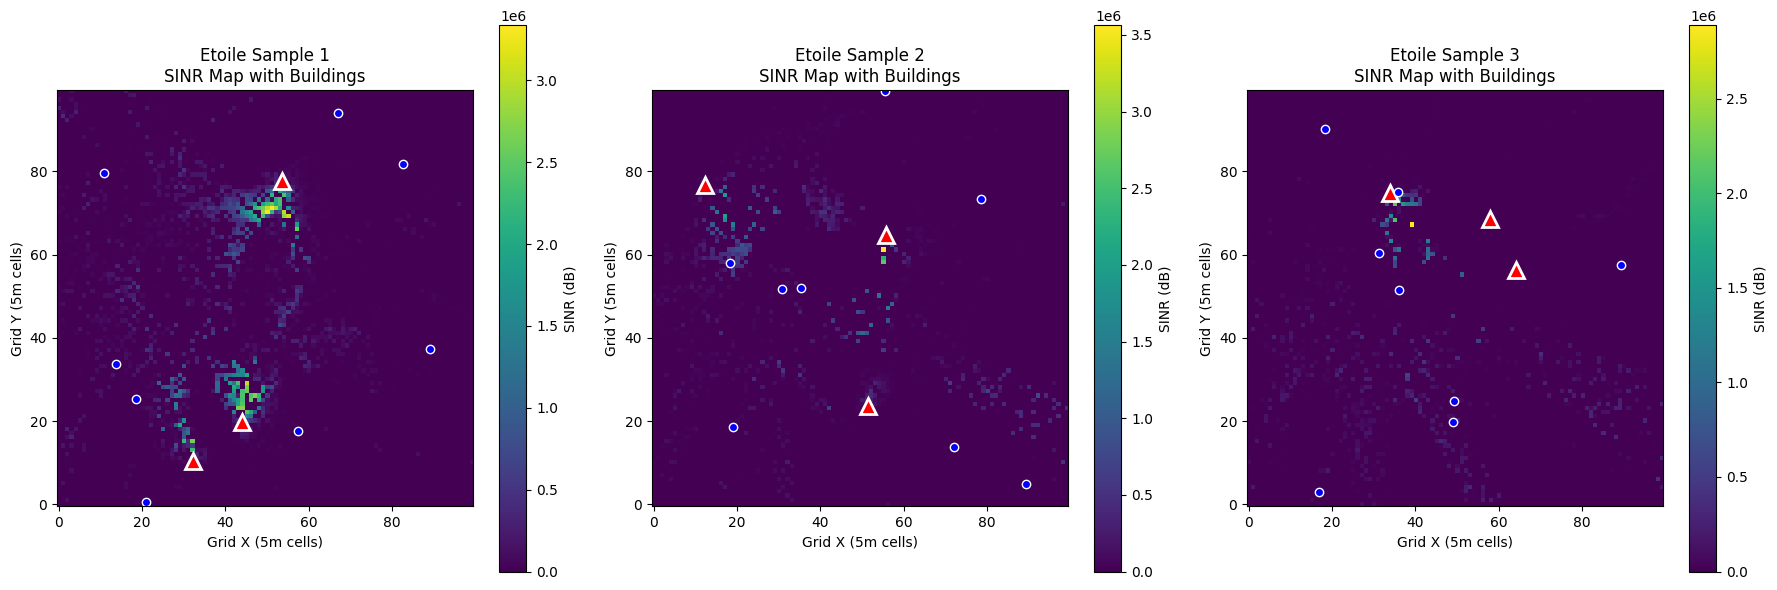

Etoile scene visualization:
- Red triangles: TX at 25m height (rooftops)
- Blue circles: RX at 1.5m height (street level)
- Dark areas: Poor signal due to building shadowing
- Bright areas: Good signal coverage


In [60]:
# Visualize Etoile scene samples
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Show first 3 Etoile samples
for i in range(min(3, len(etoile_dataset))):
    sample = etoile_dataset[i]
    
    # Plot SINR map
    im = axes[i].imshow(sample.sinr_map, cmap='viridis', aspect='equal', origin='lower')
    
    # Convert world coordinates to grid coordinates for overlay
    grid_height, grid_width = sample.sinr_map.shape
    
    def world_to_grid_etoile(pos, grid_size, world_size):
        return ((pos + world_size/2) / world_size) * grid_size
    
    # Plot TX positions (red triangles)
    for tx_pos in sample.tx_positions:
        grid_x = world_to_grid_etoile(tx_pos[0], grid_width, 500)
        grid_y = world_to_grid_etoile(tx_pos[1], grid_height, 500)
        axes[i].plot(grid_x, grid_y, 'r^', markersize=12, markeredgecolor='white', markeredgewidth=2)
    
    # Plot RX positions (blue circles) - just first few
    for rx_pos in sample.rx_positions[:8]:
        grid_x = world_to_grid_etoile(rx_pos[0], grid_width, 500)
        grid_y = world_to_grid_etoile(rx_pos[1], grid_height, 500)
        axes[i].plot(grid_x, grid_y, 'bo', markersize=6, markeredgecolor='white', markeredgewidth=1)
    
    axes[i].set_title(f'Etoile Sample {sample.sample_id}\nSINR Map with Buildings', fontsize=12)
    axes[i].set_xlabel('Grid X (5m cells)')
    axes[i].set_ylabel('Grid Y (5m cells)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], label='SINR (dB)')

plt.tight_layout()
plt.show()

print("Etoile scene visualization:")
print("- Red triangles: TX at 25m height (rooftops)")
print("- Blue circles: RX at 1.5m height (street level)")
print("- Dark areas: Poor signal due to building shadowing")
print("- Bright areas: Good signal coverage")

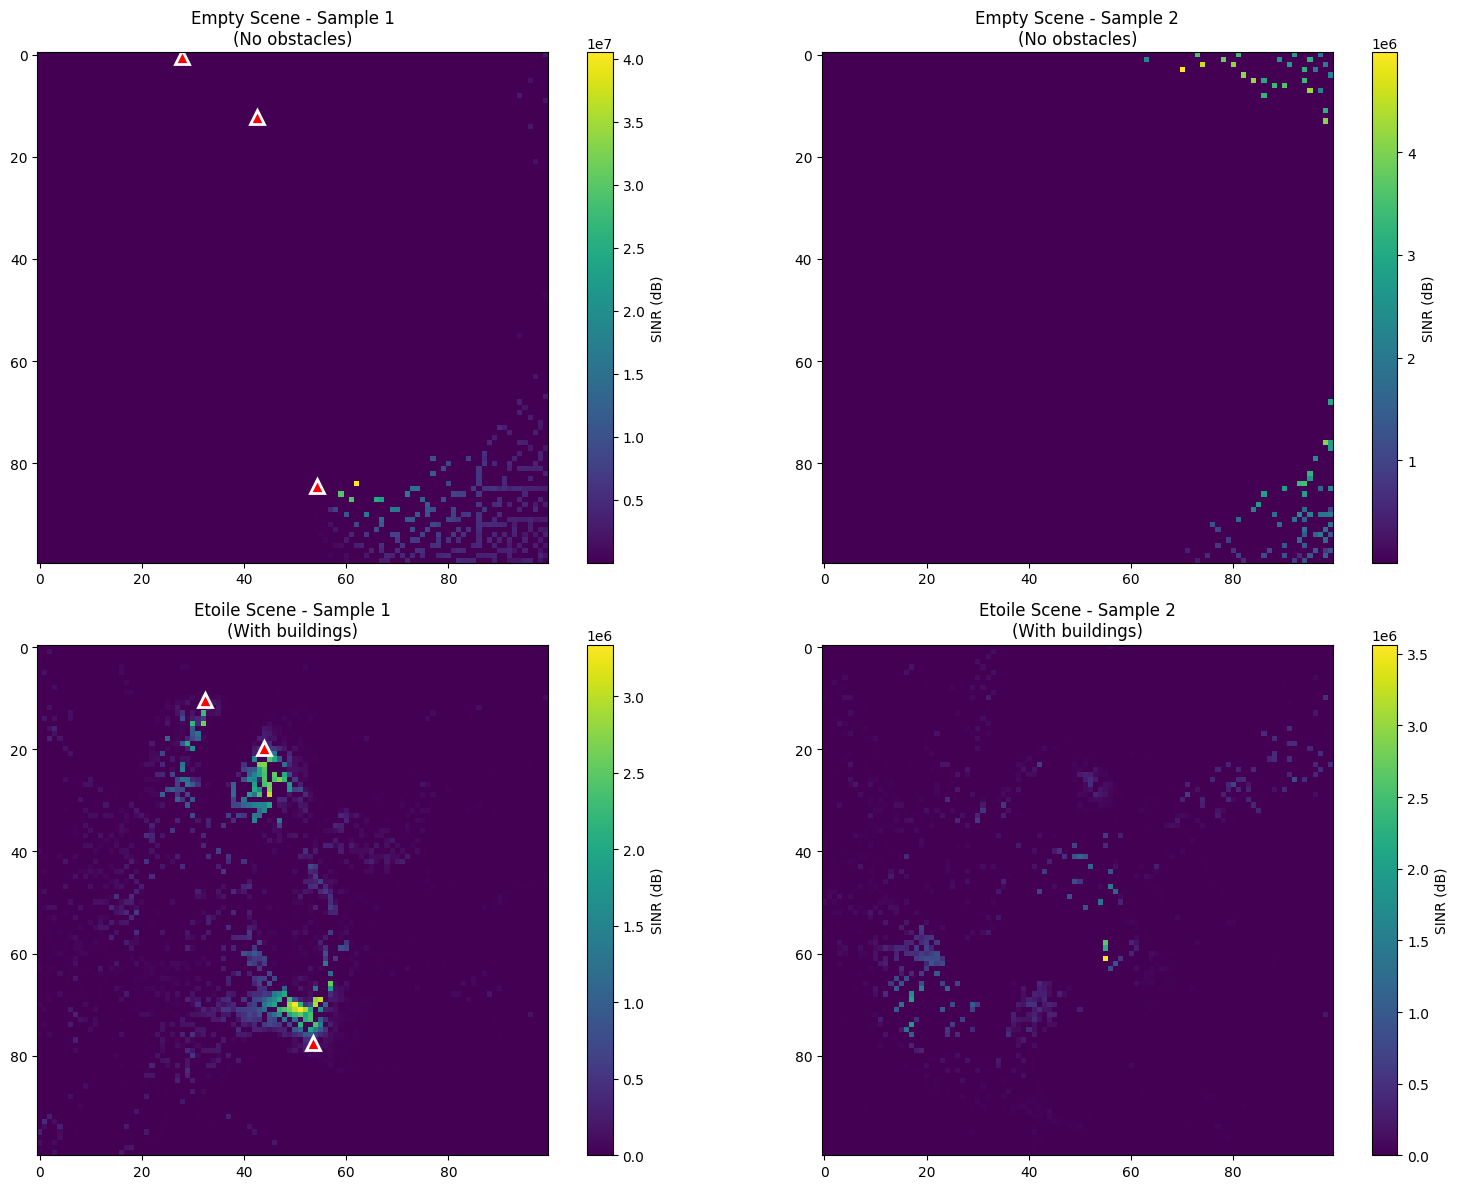

Comparison shows:
- Empty scene: Smooth signal propagation, predictable patterns
- Etoile scene: Complex propagation with shadows, reflections, and coverage holes
- Building effects create realistic urban radio environments
- Different data complexity for different ML training scenarios


In [61]:
# Compare empty scene vs Etoile scene results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top row: Empty scene
empty_sample = dataset[0]
im1 = axes[0,0].imshow(empty_sample.sinr_map, cmap='viridis', aspect='equal')
axes[0,0].set_title('Empty Scene - Sample 1\n(No obstacles)', fontsize=12)
plt.colorbar(im1, ax=axes[0,0], label='SINR (dB)')

# Add TX/RX positions for empty scene
grid_h, grid_w = empty_sample.sinr_map.shape
for tx_pos in empty_sample.tx_positions:
    gx = ((tx_pos[0] + 100) / 200) * grid_w
    gy = ((tx_pos[1] + 100) / 200) * grid_h  
    axes[0,0].plot(gx, gy, 'r^', markersize=10, markeredgecolor='white', markeredgewidth=2)

empty_sample2 = dataset[1] if len(dataset) > 1 else dataset[0]
im2 = axes[0,1].imshow(empty_sample2.sinr_map, cmap='viridis', aspect='equal')
axes[0,1].set_title('Empty Scene - Sample 2\n(No obstacles)', fontsize=12)
plt.colorbar(im2, ax=axes[0,1], label='SINR (dB)')

# Bottom row: Etoile scene  
etoile_sample1 = etoile_dataset[0]
im3 = axes[1,0].imshow(etoile_sample1.sinr_map, cmap='viridis', aspect='equal')
axes[1,0].set_title('Etoile Scene - Sample 1\n(With buildings)', fontsize=12)
plt.colorbar(im3, ax=axes[1,0], label='SINR (dB)')

# Add TX/RX positions for Etoile scene
grid_h, grid_w = etoile_sample1.sinr_map.shape
for tx_pos in etoile_sample1.tx_positions:
    gx = ((tx_pos[0] + 250) / 500) * grid_w
    gy = ((tx_pos[1] + 250) / 500) * grid_h
    axes[1,0].plot(gx, gy, 'r^', markersize=10, markeredgecolor='white', markeredgewidth=2)

etoile_sample2 = etoile_dataset[1] if len(etoile_dataset) > 1 else etoile_dataset[0]
im4 = axes[1,1].imshow(etoile_sample2.sinr_map, cmap='viridis', aspect='equal')
axes[1,1].set_title('Etoile Scene - Sample 2\n(With buildings)', fontsize=12)
plt.colorbar(im4, ax=axes[1,1], label='SINR (dB)')

plt.tight_layout()
plt.show()

print("Comparison shows:")
print("- Empty scene: Smooth signal propagation, predictable patterns")
print("- Etoile scene: Complex propagation with shadows, reflections, and coverage holes")
print("- Building effects create realistic urban radio environments")
print("- Different data complexity for different ML training scenarios")

## Key Differences: Empty Scene vs Real 3D Scenes

### Configuration Adjustments for Real Scenes:

#### **Coverage Area**:
- **Empty scene**: 200×200m grid
- **Etoile scene**: 500×500m grid (buildings span larger area)

#### **Height Positioning**:
- **TX Heights**: 25m (building rooftops) vs 10m (empty scene)
- **RX Heights**: 1.5m (street level) - same for both

#### **Cell Resolution**:
- **Empty scene**: 2×2m cells (fine detail)
- **Urban scene**: 5×5m cells (computational efficiency)

#### **Power Settings**:
- **Urban environments**: Higher TX power (46 dBm) due to building losses
- **Empty scenes**: Lower power (44 dBm) sufficient

### Computational Considerations:

- **Empty scene**: ~10-20 seconds per sample
- **Complex scenes**: 30-60+ seconds per sample (more ray interactions)
- **Memory usage**: Higher for complex scenes due to geometry processing

### Use Cases:

- **Empty scenes**: Algorithm development, baseline comparisons
- **Real scenes**: Realistic training data, deployment validation
- **Mixed datasets**: Robust model training across environments

## Super-Resolution Dataset Generation

Now let's create datasets with both low-resolution and high-resolution radio maps for super-resolution training:

In [62]:
from dataclasses import dataclass
import numpy as np
from typing import List, Dict, Any, Tuple

@dataclass
class SuperResolutionDataSample:
    """Structure to store super-resolution training data"""
    sample_id: int
    tx_positions: np.ndarray     # Shape: (n_tx, 3)
    rx_positions: np.ndarray     # Shape: (n_rx, 3) 
    sinr_map_lr: np.ndarray      # Low resolution SINR map
    sinr_map_hr: np.ndarray      # High resolution SINR map
    lr_cell_size: Tuple[float, float]  # Low res cell size
    hr_cell_size: Tuple[float, float]  # High res cell size
    config: Dict[str, Any]       # Configuration parameters

class SuperResolutionDataGenerator:
    """Generate datasets with both low and high resolution radio maps"""
    
    def __init__(self, scene, grid_size=(500, 500), lr_cell_size=(10, 10), hr_cell_size=(2, 2)):
        self.scene = scene
        self.builder = SceneTransceiverBuilder(scene)
        self.rm_solver = RadioMapSolver()
        self.grid_size = grid_size
        self.lr_cell_size = lr_cell_size  # Low resolution: 10m x 10m cells
        self.hr_cell_size = hr_cell_size  # High resolution: 2m x 2m cells
        
    def generate_sample(self, sample_id: int, config_params: Dict[str, Any]) -> SuperResolutionDataSample:
        """Generate a single super-resolution data sample"""
        
        # Create random configuration
        cfg = TransceiverConfig.randomized(**config_params)
        
        # Build transceivers in scene
        self.builder.build(cfg)
        
        # Extract positions
        tx_positions = []
        for tx in self.scene.transmitters.values():
            pos = tx.position.numpy()
            if pos.ndim > 1:
                pos = pos.squeeze()
            tx_positions.append([float(pos[0]), float(pos[1]), float(pos[2])])
        
        rx_positions = []
        for rx in self.scene.receivers.values():
            pos = rx.position.numpy()
            if pos.ndim > 1:
                pos = pos.squeeze()
            rx_positions.append([float(pos[0]), float(pos[1]), float(pos[2])])
        
        tx_positions = np.array(tx_positions)
        rx_positions = np.array(rx_positions)
        
        print(f"  Generating low-res map (cell size: {self.lr_cell_size[0]}x{self.lr_cell_size[1]}m)...")
        # Generate LOW RESOLUTION radio map
        rm_lr = self.rm_solver(
            self.scene,
            max_depth=5,
            samples_per_tx=10**6,
            cell_size=self.lr_cell_size,
            center=[0, 0, 0],
            size=list(self.grid_size),
            orientation=[0, 0, 0]
        )
        
        print(f"  Generating high-res map (cell size: {self.hr_cell_size[0]}x{self.hr_cell_size[1]}m)...")
        # Generate HIGH RESOLUTION radio map  
        rm_hr = self.rm_solver(
            self.scene,
            max_depth=5,
            samples_per_tx=10**6,
            cell_size=self.hr_cell_size,
            center=[0, 0, 0],
            size=list(self.grid_size),
            orientation=[0, 0, 0]
        )
        
        # Extract SINR data for both resolutions
        sinr_lr = rm_lr.sinr.numpy()
        sinr_hr = rm_hr.sinr.numpy()
        
        # Handle multiple transmitters by taking max SINR
        if sinr_lr.ndim == 3:
            sinr_map_lr = np.max(sinr_lr, axis=0)
        else:
            sinr_map_lr = sinr_lr
            
        if sinr_hr.ndim == 3:
            sinr_map_hr = np.max(sinr_hr, axis=0)
        else:
            sinr_map_hr = sinr_hr
        
        # Create super-resolution data sample
        sample = SuperResolutionDataSample(
            sample_id=sample_id,
            tx_positions=tx_positions,
            rx_positions=rx_positions,
            sinr_map_lr=sinr_map_lr,
            sinr_map_hr=sinr_map_hr,
            lr_cell_size=self.lr_cell_size,
            hr_cell_size=self.hr_cell_size,
            config=config_params
        )
        
        return sample
    
    def generate_dataset(self, n_samples: int, config_template: Dict[str, Any], 
                        show_progress: bool = True) -> List[SuperResolutionDataSample]:
        """Generate multiple super-resolution data samples"""
        
        print(f"Generating {n_samples} super-resolution samples...")
        print(f"Low-res: {self.lr_cell_size[0]}x{self.lr_cell_size[1]}m cells")
        print(f"High-res: {self.hr_cell_size[0]}x{self.hr_cell_size[1]}m cells")
        print(f"Coverage: {self.grid_size[0]}x{self.grid_size[1]}m")
        
        dataset = []
        
        for i in range(n_samples):
            print(f"\nProcessing sample {i+1}/{n_samples}")
            
            # Use different seed for each sample
            config = config_template.copy()
            config['seed'] = i + 200  # Start from 200 to avoid conflicts
            
            sample = self.generate_sample(i + 1, config)
            dataset.append(sample)
            
            if show_progress:
                print(f"  ✓ Sample {i+1} complete - LR: {sample.sinr_map_lr.shape}, HR: {sample.sinr_map_hr.shape}")
            
        print(f"\nSuper-resolution dataset generation complete: {len(dataset)} samples")
        return dataset
    
    def save_dataset(self, dataset: List[SuperResolutionDataSample], filename: str):
        """Save super-resolution dataset"""
        with open(filename, 'wb') as f:
            pickle.dump(dataset, f)
        print(f"Super-resolution dataset saved to {filename}")

print("SuperResolutionDataGenerator class defined")

SuperResolutionDataGenerator class defined


In [63]:
# Create super-resolution data generator for Etoile scene
sr_generator = SuperResolutionDataGenerator(
    scene_etoile,
    grid_size=(500, 500),      # 500x500m coverage
    lr_cell_size=(10, 10),     # Low-res: 10m x 10m cells → 50x50 grid
    hr_cell_size=(2, 2)        # High-res: 2m x 2m cells → 250x250 grid
)

print("Super-resolution generator configured:")
print(f"- Coverage area: {sr_generator.grid_size[0]}x{sr_generator.grid_size[1]}m")
print(f"- Low-res resolution: {sr_generator.lr_cell_size[0]}x{sr_generator.lr_cell_size[1]}m → {sr_generator.grid_size[0]//sr_generator.lr_cell_size[0]}x{sr_generator.grid_size[1]//sr_generator.lr_cell_size[1]} grid")
print(f"- High-res resolution: {sr_generator.hr_cell_size[0]}x{sr_generator.hr_cell_size[1]}m → {sr_generator.grid_size[0]//sr_generator.hr_cell_size[0]}x{sr_generator.grid_size[1]//sr_generator.hr_cell_size[1]} grid")
print(f"- Upscaling factor: {sr_generator.lr_cell_size[0] // sr_generator.hr_cell_size[0]}x")

Super-resolution generator configured:
- Coverage area: 500x500m
- Low-res resolution: 10x10m → 50x50 grid
- High-res resolution: 2x2m → 250x250 grid
- Upscaling factor: 5x


In [64]:
# Generate super-resolution dataset
print("Generating super-resolution dataset for Etoile scene...")
print("Note: This will take longer since we generate both LR and HR maps for each sample")

n_sr_samples = 3  # Start with fewer samples due to double computation time
start_time = time.time()

sr_dataset = sr_generator.generate_dataset(
    n_sr_samples,
    etoile_config,  # Use the same Etoile configuration as before
    show_progress=True
)

end_time = time.time()
print(f"\nSuper-resolution dataset generation completed in {end_time - start_time:.1f} seconds")
print(f"Average time per sample: {(end_time - start_time) / n_sr_samples:.1f} seconds")

# Examine the first sample
sample = sr_dataset[0]
print(f"\nSuper-resolution sample details:")
print(f"- Sample ID: {sample.sample_id}")
print(f"- TX positions shape: {sample.tx_positions.shape}")
print(f"- RX positions shape: {sample.rx_positions.shape}")
print(f"- Low-res SINR map shape: {sample.sinr_map_lr.shape}")
print(f"- High-res SINR map shape: {sample.sinr_map_hr.shape}")
print(f"- Upscaling factor: {sample.sinr_map_hr.shape[0] // sample.sinr_map_lr.shape[0]}x")
print(f"- LR cell size: {sample.lr_cell_size}")
print(f"- HR cell size: {sample.hr_cell_size}")

Generating super-resolution dataset for Etoile scene...
Note: This will take longer since we generate both LR and HR maps for each sample
Generating 3 super-resolution samples...
Low-res: 10x10m cells
High-res: 2x2m cells
Coverage: 500x500m

Processing sample 1/3
  Generating low-res map (cell size: 10x10m)...
  Generating high-res map (cell size: 2x2m)...
  ✓ Sample 1 complete - LR: (50, 50), HR: (250, 250)

Processing sample 2/3
  Generating low-res map (cell size: 10x10m)...
  Generating high-res map (cell size: 2x2m)...
  ✓ Sample 2 complete - LR: (50, 50), HR: (250, 250)

Processing sample 3/3
  Generating low-res map (cell size: 10x10m)...
  Generating high-res map (cell size: 2x2m)...
  ✓ Sample 3 complete - LR: (50, 50), HR: (250, 250)

Super-resolution dataset generation complete: 3 samples

Super-resolution dataset generation completed in 4.1 seconds
Average time per sample: 1.4 seconds

Super-resolution sample details:
- Sample ID: 1
- TX positions shape: (3, 3)
- RX positio

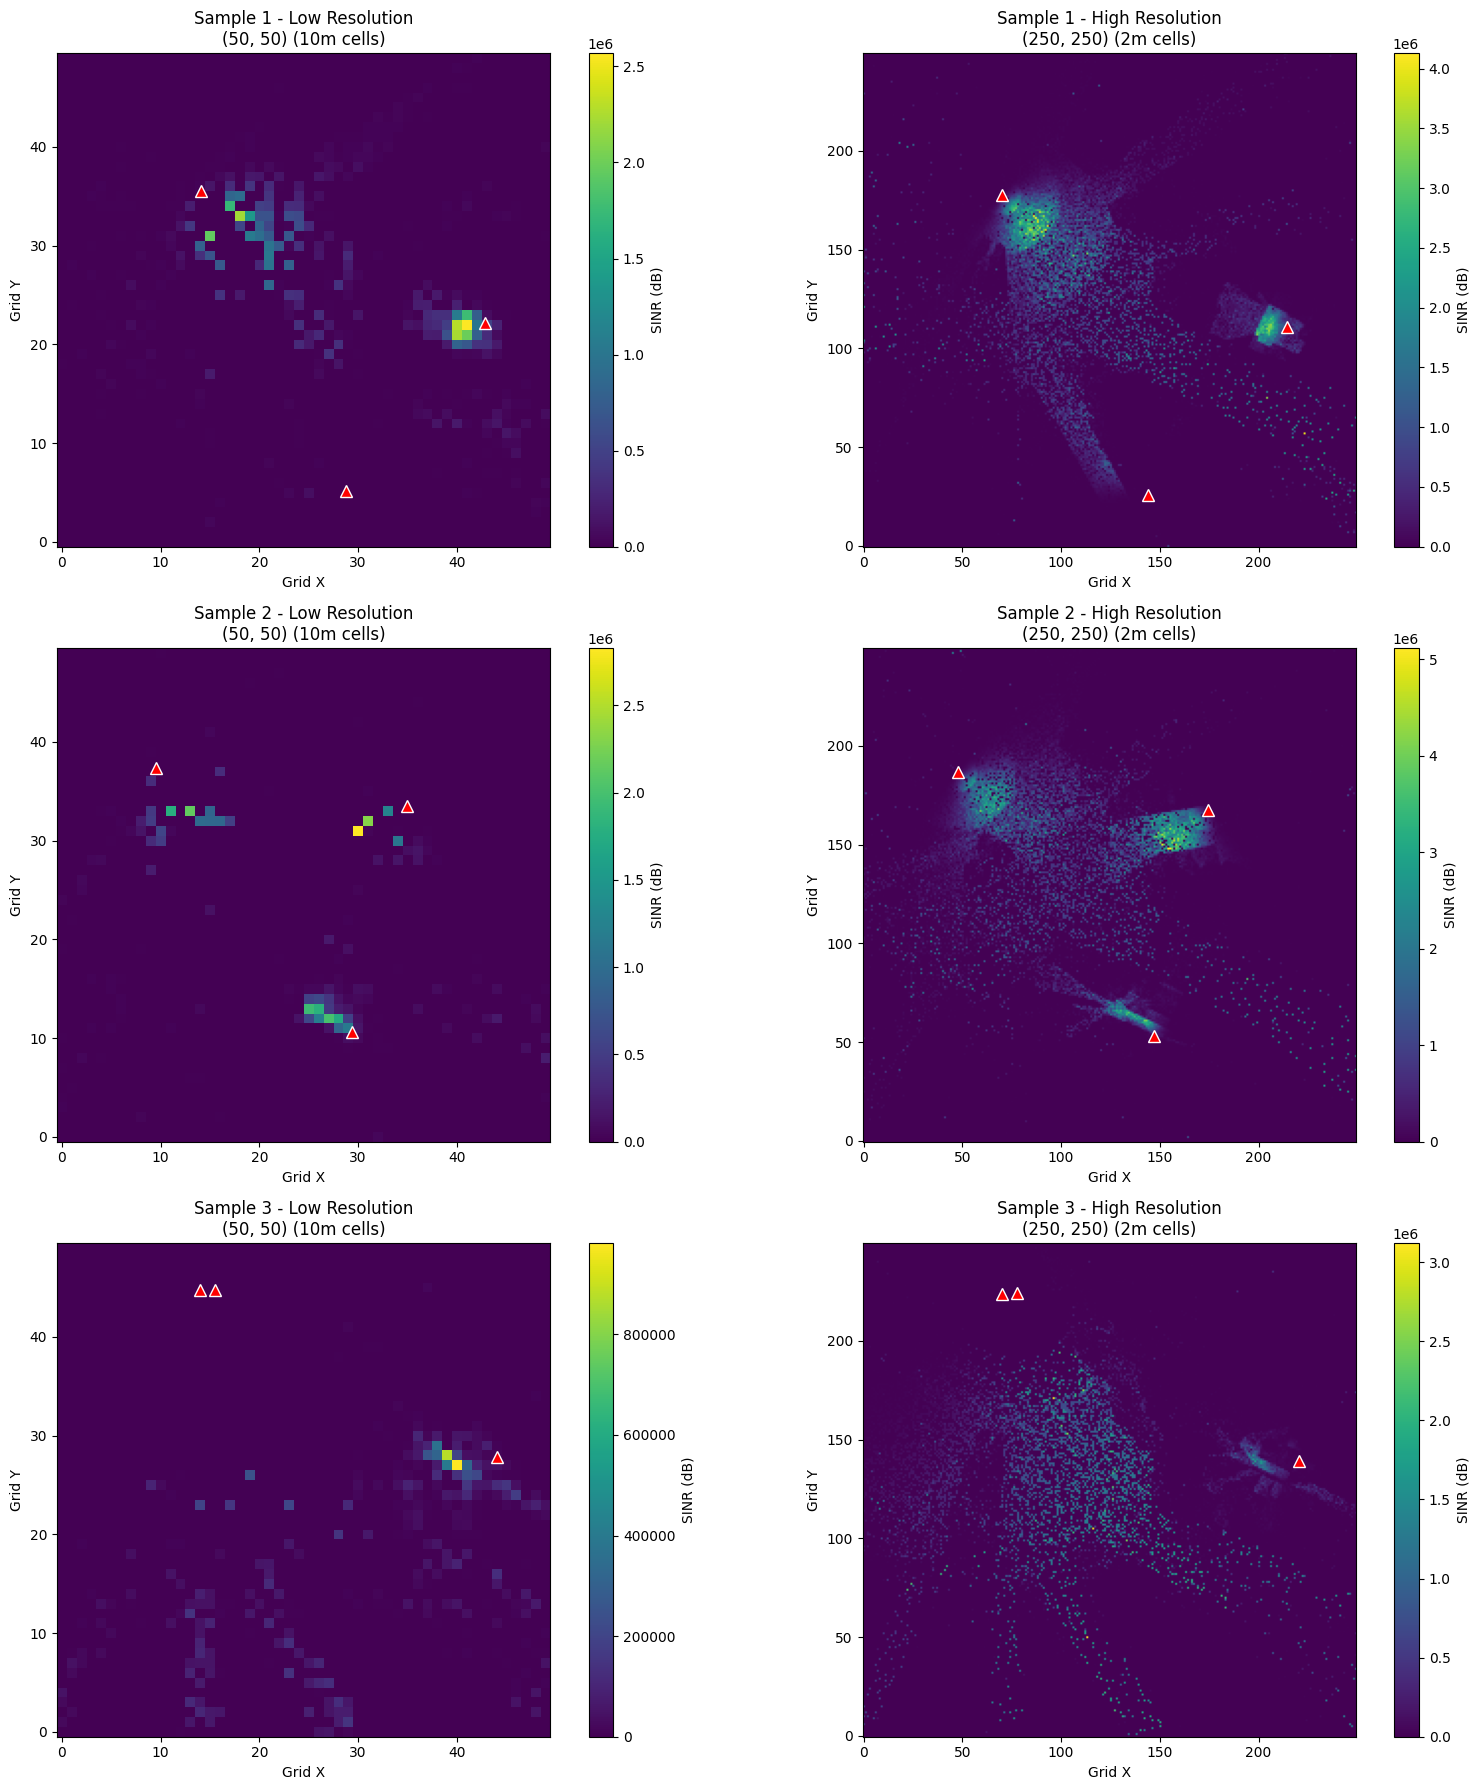

Super-resolution visualization:
- Left column: Low-resolution radio maps (10m cells)
- Right column: High-resolution radio maps (2m cells)
- Red triangles: Transmitter positions
- Notice the increased detail and smoother gradients in HR maps


In [65]:
# Visualize low-res vs high-res radio maps
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Show first 3 samples, each with LR and HR versions
for i in range(min(3, len(sr_dataset))):
    sample = sr_dataset[i]
    
    # Left column: Low Resolution
    im_lr = axes[i,0].imshow(sample.sinr_map_lr, cmap='viridis', aspect='equal', origin='lower')
    axes[i,0].set_title(f'Sample {sample.sample_id} - Low Resolution\n{sample.sinr_map_lr.shape} ({sample.lr_cell_size[0]}m cells)', fontsize=12)
    axes[i,0].set_xlabel('Grid X')
    axes[i,0].set_ylabel('Grid Y')
    plt.colorbar(im_lr, ax=axes[i,0], label='SINR (dB)')
    
    # Right column: High Resolution  
    im_hr = axes[i,1].imshow(sample.sinr_map_hr, cmap='viridis', aspect='equal', origin='lower')
    axes[i,1].set_title(f'Sample {sample.sample_id} - High Resolution\n{sample.sinr_map_hr.shape} ({sample.hr_cell_size[0]}m cells)', fontsize=12)
    axes[i,1].set_xlabel('Grid X')
    axes[i,1].set_ylabel('Grid Y')
    plt.colorbar(im_hr, ax=axes[i,1], label='SINR (dB)')
    
    # Add TX positions to both maps
    def world_to_grid_sr(pos, grid_size, world_size):
        return ((pos + world_size/2) / world_size) * grid_size
    
    # LR map TX positions
    for tx_pos in sample.tx_positions:
        grid_x = world_to_grid_sr(tx_pos[0], sample.sinr_map_lr.shape[1], 500)
        grid_y = world_to_grid_sr(tx_pos[1], sample.sinr_map_lr.shape[0], 500)
        axes[i,0].plot(grid_x, grid_y, 'r^', markersize=8, markeredgecolor='white', markeredgewidth=1)
    
    # HR map TX positions
    for tx_pos in sample.tx_positions:
        grid_x = world_to_grid_sr(tx_pos[0], sample.sinr_map_hr.shape[1], 500)
        grid_y = world_to_grid_sr(tx_pos[1], sample.sinr_map_hr.shape[0], 500)
        axes[i,1].plot(grid_x, grid_y, 'r^', markersize=8, markeredgecolor='white', markeredgewidth=1)

plt.tight_layout()
plt.show()

print("Super-resolution visualization:")
print("- Left column: Low-resolution radio maps (10m cells)")
print("- Right column: High-resolution radio maps (2m cells)")
print("- Red triangles: Transmitter positions")
print("- Notice the increased detail and smoother gradients in HR maps")

In [66]:
# Save the super-resolution dataset
sr_filename = "data/etoile_super_resolution_dataset.pkl"
sr_generator.save_dataset(sr_dataset, sr_filename)

# Calculate file size and statistics
import os
file_size = os.path.getsize(sr_filename) / (1024 * 1024)  # MB

print(f"\nSuper-resolution dataset summary:")
print(f"- Number of samples: {len(sr_dataset)}")
print(f"- Transmitters per sample: {sr_dataset[0].tx_positions.shape[0]}")
print(f"- Receivers per sample: {sr_dataset[0].rx_positions.shape[0]}")
print(f"- Low-res SINR maps: {sr_dataset[0].sinr_map_lr.shape} ({sr_dataset[0].lr_cell_size})")
print(f"- High-res SINR maps: {sr_dataset[0].sinr_map_hr.shape} ({sr_dataset[0].hr_cell_size})")
print(f"- Scene: Etoile (realistic urban environment)")
print(f"- Coverage: 500x500m")
print(f"- Upscaling factor: 5x (10m → 2m cell size)")
print(f"- File size: {file_size:.2f} MB")

# Calculate data sizes
lr_size = sr_dataset[0].sinr_map_lr.size * 4 / 1024  # KB (float32)
hr_size = sr_dataset[0].sinr_map_hr.size * 4 / 1024  # KB (float32)
print(f"\nPer sample data sizes:")
print(f"- Low-res map: {lr_size:.1f} KB")
print(f"- High-res map: {hr_size:.1f} KB") 
print(f"- Total per sample: {(lr_size + hr_size):.1f} KB")

Super-resolution dataset saved to data/etoile_super_resolution_dataset.pkl

Super-resolution dataset summary:
- Number of samples: 3
- Transmitters per sample: 3
- Receivers per sample: 15
- Low-res SINR maps: (50, 50) ((10, 10))
- High-res SINR maps: (250, 250) ((2, 2))
- Scene: Etoile (realistic urban environment)
- Coverage: 500x500m
- Upscaling factor: 5x (10m → 2m cell size)
- File size: 0.75 MB

Per sample data sizes:
- Low-res map: 9.8 KB
- High-res map: 244.1 KB
- Total per sample: 253.9 KB


## Super-Resolution Dataset Features

### Perfect for ML Super-Resolution Training:

#### **Input-Target Pairs**:
- **Input**: Low-resolution SINR maps (50×50, 10m cells)
- **Target**: High-resolution SINR maps (250×250, 2m cells)
- **Scale Factor**: 5× upscaling (realistic for super-resolution)

#### **Realistic Urban Environment**:
- **Complex propagation**: Buildings create shadows, reflections, multipath
- **Varied patterns**: Different TX/RX configurations per sample
- **Real-world applicable**: Etoile scene represents actual urban deployment

#### **Data Structure**:
```python
sample = sr_dataset[0]
sample.sinr_map_lr    # Low-res input (50, 50)
sample.sinr_map_hr    # High-res target (250, 250)  
sample.tx_positions   # Transmitter locations
sample.rx_positions   # Receiver locations
```

#### **Training Applications**:
- **SRCNN**: Classical CNN super-resolution
- **ESRGAN**: Generative adversarial networks
- **Transformer-based**: Vision transformers for SR
- **Physics-informed**: Include TX/RX positions as additional inputs

#### **Dataset Scaling**:
- Current: 3 samples for testing
- Small training: 100-200 samples
- Full training: 1000+ samples
- Production: 5000+ samples with data augmentation